In [1]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapterPlus

In [2]:
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "models/image_encoder"
ip_ckpt = "models/ip-adapter-plus_sd15.bin"
device = "cuda"

In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

In [4]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

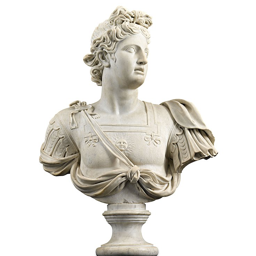

In [5]:
# read image prompt
image = Image.open("assets/images/statue.png")
image.resize((256, 256))

In [6]:
# load ip-adapter
ip_model = IPAdapterPlus(pipe, image_encoder_path, ip_ckpt, device, num_tokens=16)

  0%|          | 0/50 [00:00<?, ?it/s]

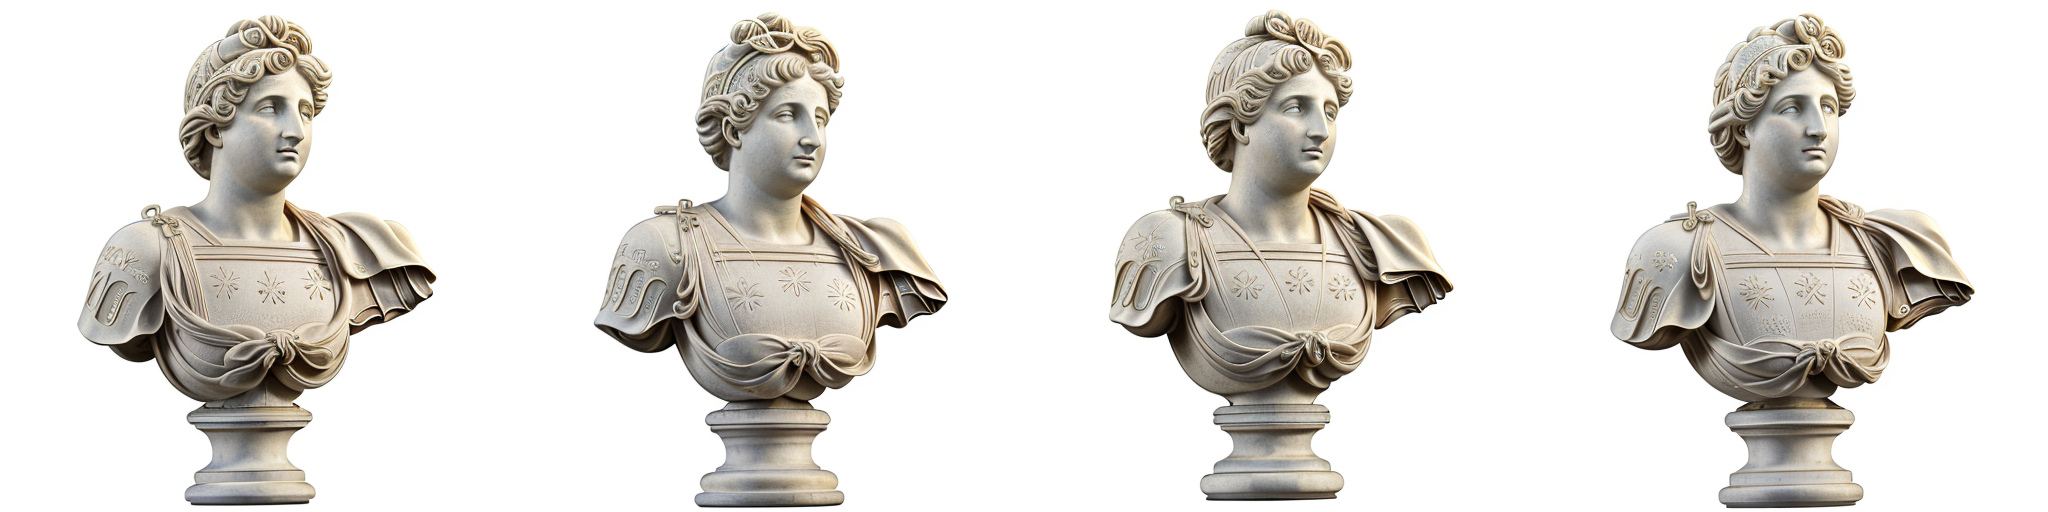

In [7]:
# only image prompt
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

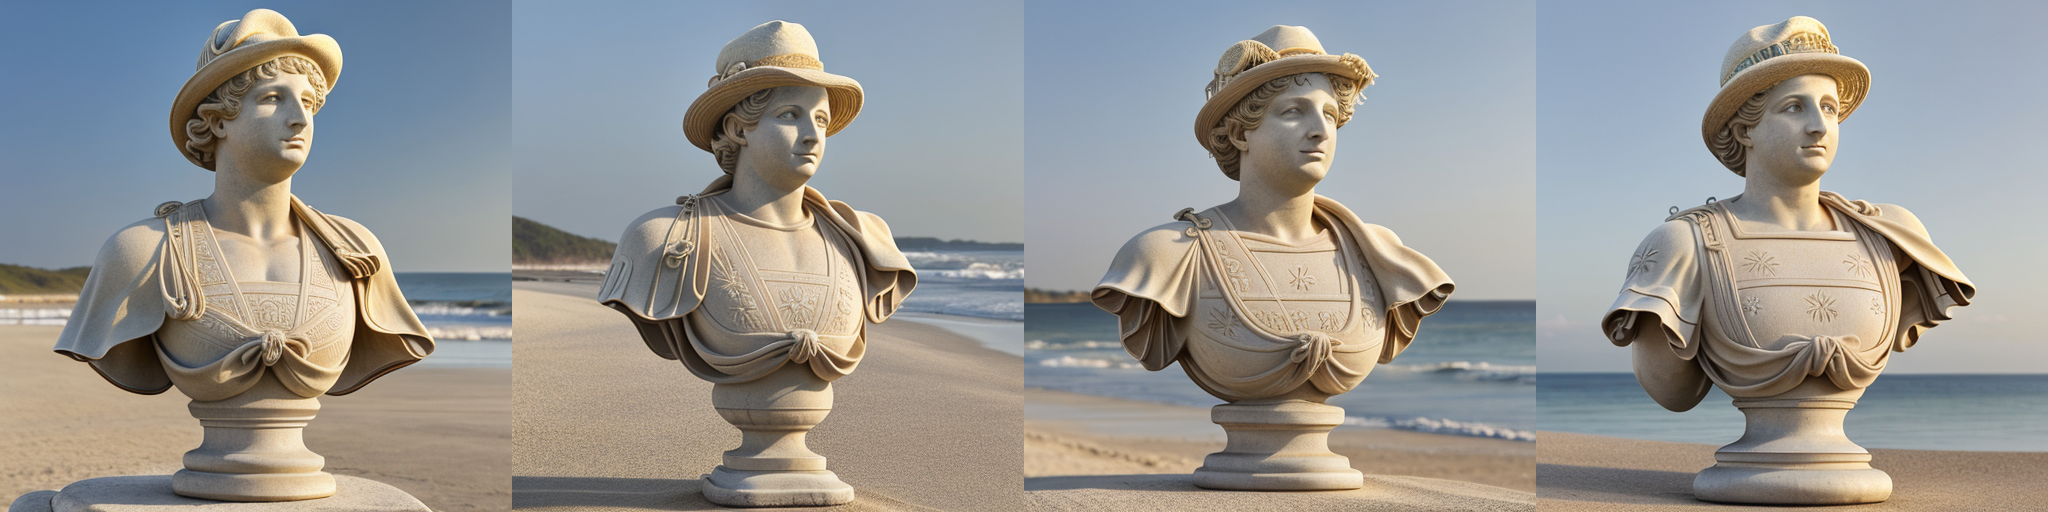

In [8]:
# multimodal prompts
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42,
        prompt="best quality, high quality, wearing a hat on the beach", scale=0.6)
grid = image_grid(images, 1, 4)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

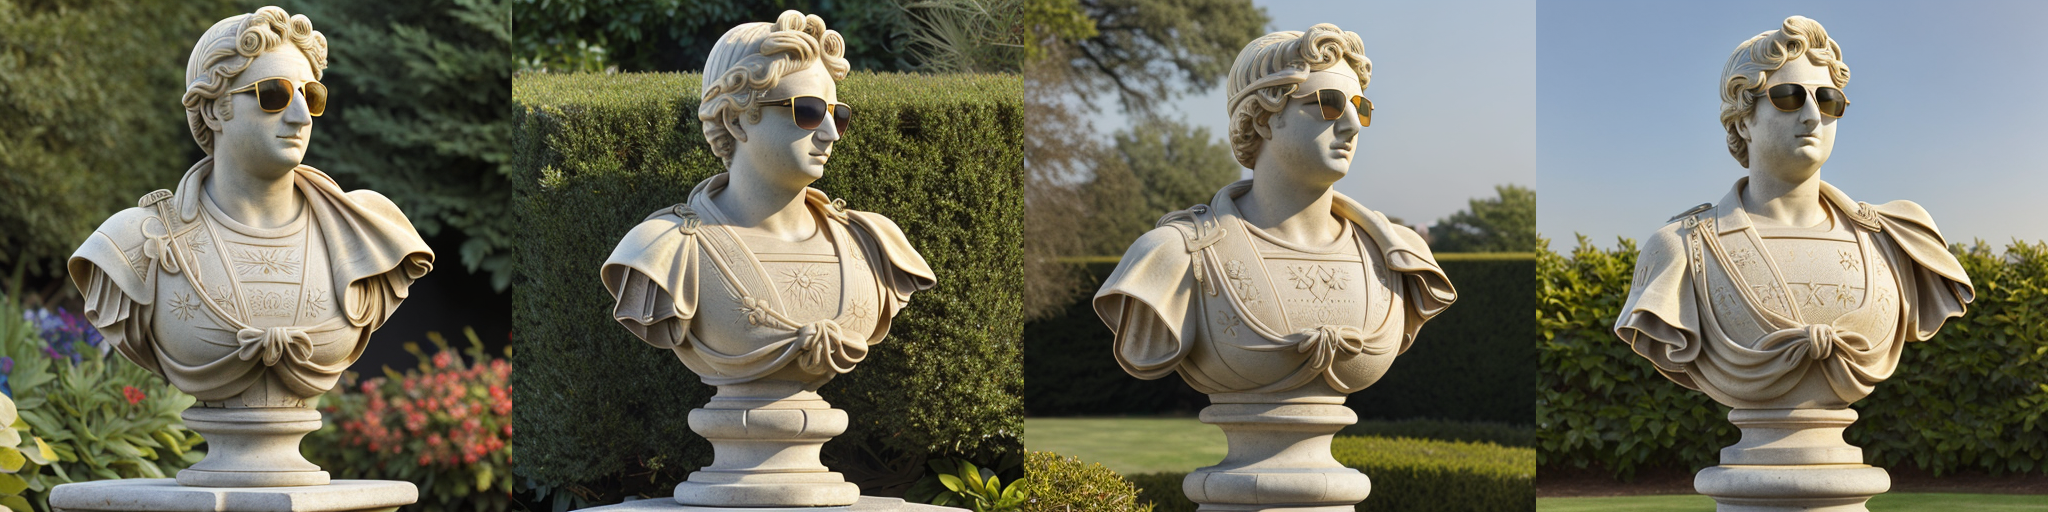

In [9]:
# multimodal prompts
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42,
        prompt="best quality, high quality, wearing sunglasses in a garden", scale=0.6)
grid = image_grid(images, 1, 4)
grid